### Import Libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # "jax" or "tensorflow" or "torch" 
# os.environ["WANDB_SILENT"] = "false" # for wandb

import keras_nlp
import keras_core as keras
import keras_core.backend as K


import torch
# import jax
import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

2024-02-05 18:32:02.474988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/var/folders/jq/kxrl2tcj53z555vfr3_jd16w6ybq2c/T/ipykernel_15060/1887472780.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [2]:
print("TensorFlow:", tf.__version__)
# print("JAX:", jax.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.15.0
Keras: 0.1.7
KerasNLP: 0.6.3


### Configuration

In [3]:
class CFG:
    verbose = 0  # Verbosity
    
    wandb = True  # Weights & Biases logging
    competition = 'llm-detect-ai-generated-text'  # Competition name
    _wandb_kernel = 'awsaf49'  # WandB kernel
    comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description
    
    preset = "deberta_v3_base_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length
    
    device = 'TPU'  # Device
    
    seed = 42  # Random seed
    
    num_folds = 5  # Total folds
    selected_folds = [0, 1]  # Folds to train on
    
    epochs = 3 # Training epochs
    batch_size = 3  # Batch size
    drop_remainder = True  # Drop incomplete batches
    cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM
    
    scheduler = 'cosine'  # Learning rate scheduler
    
    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

In [4]:
keras.utils.set_random_seed(CFG.seed)

In [5]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

        # instantiate a distribution strategy
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [6]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on CPU


### Training Data

In [7]:
BASE_PATH = '/Users/raniva/Desktop/AI-Generated-Text-Detection/data'

# Train Data: 1,378
# Sample:


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real


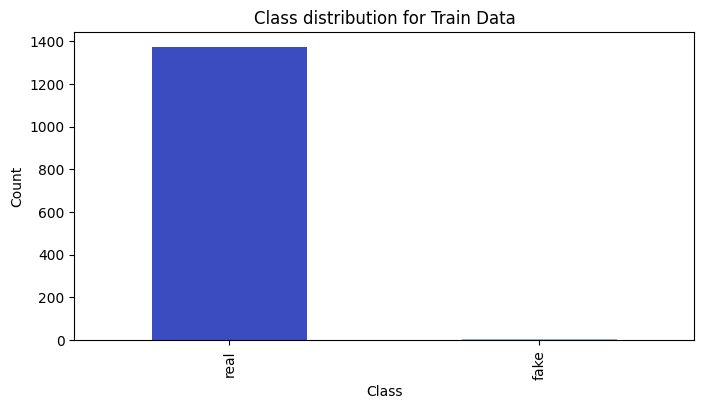

In [8]:
df = pd.read_csv(f'{BASE_PATH}/train_essays.csv')  # Read CSV file into a DataFrame
df['label'] = df.generated.copy()
df['name'] = df.generated.map(CFG.label2name)  # Map answer labels using name-to-label mapping

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()

# External Data: 28,210
# Sample:


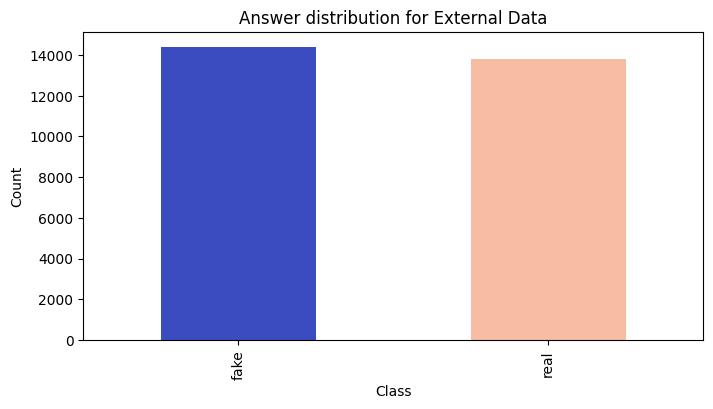

In [9]:
# Load external data
ext_df1 = pd.read_csv(f'{BASE_PATH}/train_drcat_04.csv')
ext_df2 = pd.read_csv(f'{BASE_PATH}/argugpt.csv')[['id','text','model']]

ext_df2.rename(columns={'model':'source'}, inplace=True)
ext_df2['label'] = 1

ext_df = pd.concat([
    ext_df1[ext_df1.source=='persuade_corpus'].sample(10000),
    ext_df1[ext_df1.source!='persuade_corpus'],
#     ext_df2,
])

# ext_real_df = ext_df[['id', 'text']].copy()
# ext_real_df['label']  = 0

# ext_fake_df = ext_df[['id', 'source_text']].copy()
# ext_fake_df.rename(columns={"source_text":"text"}, inplace=True)
# ext_fake_df['label']  = 1

# ext_df = pd.concat([ext_real_df, ext_fake_df], axis=0)
ext_df['name'] = ext_df.label.map(CFG.label2name)

# Display information about the external data
print("# External Data: {:,}".format(len(ext_df)))
print("# Sample:")
ext_df.head(2)

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
ext_df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

In [10]:
df = ext_df.copy().reset_index(drop=True) # pd.concat([ext_df, df], axis=0)
df.head()

,essay_id,text,label,source,prompt,fold,name
0,83BB96F966DB,Students would benefit from being able to atte...,0,persuade_corpus,NaN,2,real
1,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,2,real
2,4A028F63CFCA,The human body is a complex network of muscles...,0,persuade_corpus,NaN,7,real
3,5782F64504B9,Summer projects are a means by which schools a...,0,persuade_corpus,NaN,9,real
4,97DD2D770B03,"Dear Mr. Senator,\n\nI have decided to express...",0,persuade_corpus,NaN,6,real


### Data Split

In [11]:
from sklearn.model_selection import StratifiedKFold  # Import package

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

df = df.reset_index(drop=True)  # Reset dataframe index

df['stratify'] = df.label.astype(str)+df.source.astype(str)

df["fold"] = -1  # New 'fold' column

# Assign folds using StratifiedKFold
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'])):
    df.loc[val_idx, 'fold'] = fold

# Display label distribution for each fold
df.groupby(["fold", "name", "source"]).size()

/Users/raniva/Desktop/AI-Generated-Text-Detection/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


fold  name  source           
0     fake  chat_gpt_moth         484
            darragh_claude_v6     200
            darragh_claude_v7     200
            falcon_180b_v1        211
            llama2_chat           484
                                 ... 
4     fake  radek_500             100
            train_essays            1
      real  original_moth         484
            persuade_corpus      2000
            train_essays          275
Length: 63, dtype: int64

### Preprocessing

The preprocessor takes input strings and transforms them into a dictionary (token_ids, padding_mask) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [13]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

In [14]:
inp = preprocessor(df.text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (200,)
padding_mask : (200,)


In [15]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

In [16]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

### Fetch Train/Valid Dataset

The function below generates the training and validation datasets for a given fold.

In [17]:

def get_datasets(fold):
    train_df = df[df.fold!=fold].sample(frac=1)  # Get training fold data
        
    train_texts = train_df.text.tolist()  # Extract training texts
    train_labels = train_df.label.tolist()  # Extract training labels
    
    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True)

    valid_df = df[df.fold==fold].sample(frac=1)  # Get validation fold data
    valid_texts = valid_df.text.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels
    
    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False)
    
    return (train_ds, train_df), (valid_ds, valid_df)  # Return datasets and dataframes

### Wandb (Weights & Bisases)

To monitor the training of my text-based model, I'll make use of Weights & Biases. Weights & Biases (W&B) is an MLOps platform that offers experiment tracking, dataset versioning, and model management functionalities, aiding in efficient model development.

In [18]:
import wandb  # Import wandb library for experiment tracking

try:
    from kaggle_secrets import UserSecretsClient  # Import UserSecretsClient
    user_secrets = UserSecretsClient()  # Create secrets client instance
    api_key = user_secrets.get_secret("WANDB")  # Get API key from Kaggle secrets
    wandb.login(key=api_key)  # Login to wandb with the API key
    anonymous = None  # Set anonymous mode to None
except:
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)  # Login to wandb anonymously and relogin if needed

wandb: Appending key for api.wandb.ai to your netrc file: /Users/raniva/.netrc


In [19]:
# Initializes the W&B run with a config file and W&B run settings.
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary
    config.update({"fold": int(fold)})  # Add fold to config
    run = wandb.init(project="llm-fake-text",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

# Log best result for error analysis
def log_wandb():
    wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr]  # Return WandB callbacks

### Learning Rate Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at lr_start and gradually tapers down to lr_min using various techniques, including:

step: Lowering the learning rate in step-wise manner resembling stairs.

cos: Utilizing a cosine curve to gradually reduce the learning rate.

exp: Exponentially decreasing the learning rate.

In [20]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

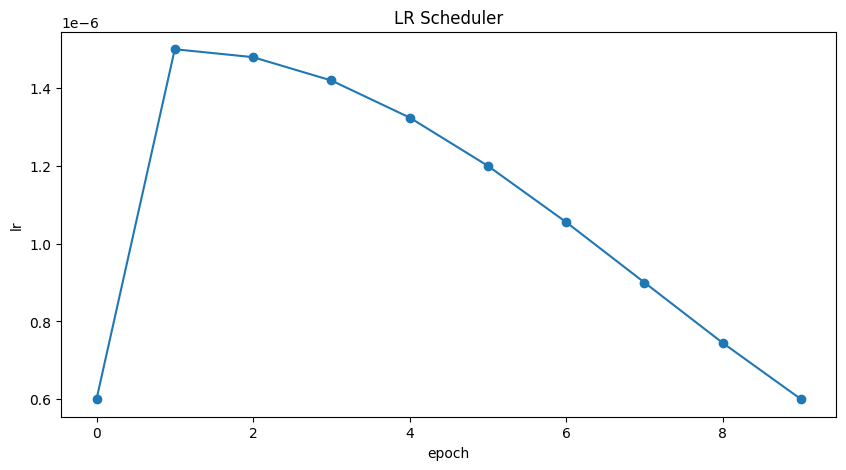

In [21]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

### Callbacks

The function below will gather all the training callbacks, such as lr_scheduler, model_checkpoint, wandb_logger, and etc.

In [22]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)  # Get lr callback
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor='val_auc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks

    if CFG.wandb:  # If WandB is enabled
        wb_cbs = get_wb_callbacks(fold)  # Get WandB callbacks
        callbacks.extend(wb_cbs) 
        
    return callbacks  # Return the list of callbacks

### Modelling (KerasNLP classifier)

In [23]:
def build_model():
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1 # one output per one option, for five options total 5 outputs
    )
    inputs = classifier.input
    logits = classifier(inputs)
        
    # Compute final output
    outputs = keras.layers.Activation("sigmoid")(logits)
    model = keras.Model(inputs, outputs)
    
    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=keras.optimizers.AdamW(5e-6),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        metrics=[
            keras.metrics.AUC(name="auc"),
        ],
        jit_compile=True
    )
    return model

In [24]:
# with strategy.scope
model = build_model()

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ token_ids           │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ deberta_v3_classif… │ (None, 1)         │ 184,42… │ padding_mask[0][0],  │
│ (DebertaV3Classifi… │                   │         │ token_ids[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 1)         │       0 │ deberta_v3_classifi… │
│ (Activation)        │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# keras.utils.plot_model(model, show_shapes=True)

### Training

In [30]:
for fold in CFG.selected_folds:
    # Initialize Weights and Biases if enabled
    if CFG.wandb:
        run = wandb_init(fold)

    # Get train and validation datasets
    (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)
    
    # Get callback functions for training
    callbacks = get_callbacks(fold)

    # Print training information
    print('#' * 50)
    print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
    print(f'\tNum Train: {len(train_df)} | Num Valid: {len(valid_df)}')
    print('#' * 50)
    
    # Clear TensorFlow session and build the model within the strategy scope
    K.clear_session()
    with strategy.scope():
        model = build_model()

    # Start training the model
    history = model.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        callbacks=callbacks,
        steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas),
    )
    
    # Find the epoch with the best validation accuracy
    best_epoch = np.argmax(model.history.history['val_auc'])
    best_auc = model.history.history['val_auc'][best_epoch]
    best_loss = model.history.history['val_loss'][best_epoch]

    # Print and display best results
    print(f'\n{"=" * 17} FOLD {fold} RESULTS {"=" * 17}')
    print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST AUC   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
    print('=' * 50)
    
    # Log best result on Weights and Biases (wandb) if enabled
    if CFG.wandb:
        log_wandb()  # Log results
        wandb.run.finish()  # Finish the run
#         display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard
    print("\n\n")

##################################################
	Fold: 1 | Model: deberta_v3_base_en
	Batch Size: 3 | Scheduler: cosine
	Num Train: 22568 | Num Valid: 5642
##################################################
Epoch 1/3


2024-02-05 21:03:53.707166: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-05 21:04:32.521283: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sentencepiece_kernels.cc:277 : NOT_FOUND: Resource localhost/_0_SentencepieceOp/N10tensorflow4text12_GLOBAL__N_121SentencepieceResourceE does not exist.
2024-02-05 21:04:32.521338: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sentencepiece_kernels.cc:277 : NOT_FOUND: Resource localhost/_0_SentencepieceOp/N10tensorflow4text12_GLOBAL__N_121SentencepieceResourceE does not exist.
2024-02-05 21:04:32.521361: W tensorflow/core/framework/op_kernel.cc:1839] O

NotFoundError: Graph execution error:

Detected at node deberta_v3_preprocessor_1/deberta_v3_tokenizer_1/SentenceTokenizer/SentencepieceTokenizeOp defined at (most recent call last):
<stack traces unavailable>
Resource localhost/_0_SentencepieceOp/N10tensorflow4text12_GLOBAL__N_121SentencepieceResourceE does not exist.
	 [[{{node deberta_v3_preprocessor_1/deberta_v3_tokenizer_1/SentenceTokenizer/SentencepieceTokenizeOp}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_179521]

### Prediction

In [ ]:
# Make predictions using the trained model on last validation data
predictions = model.predict(
    valid_ds,
    batch_size=min(CFG.batch_size * CFG.replicas * 2, len(valid_df)), # max batch size = valid size
    verbose=1
)

In [ ]:
# Format predictions and true answers
pred_answers = (predictions > 0.5).astype(int).squeeze()
true_answers = valid_df.label.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text  = row.text
    pred_answer = CFG.label2name[pred_answers[i]]
    true_answer = CFG.label2name[true_answers[i]]
    print(f"❓ Text {i+1}:\n{text[:100]} .... {text[-100:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-"*90, "\n")